## **Assignment 5 - Exercise 2 - Text Classification with Convolutional Neural Networks**

<b><u>Contributor</u></b>: Dimitris Vougioukos - f3352411

The following is the implementation of the exercise 2 of the fifth assignment of the Text Analytics course on text classification with Convolutional Neural Networks (CNNs)

### **Exercise 2**

In [ ]:
# Importing required libraries
import random
import nltk
import gensim.downloader as api
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import movie_reviews, stopwords
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    classification_report,
)
from tabulate import tabulate


# Downloading NLTK datasets
nltk.download("movie_reviews")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Explore the `movie_reviews` dataset

In [ ]:
# Getting all the file ids
file_ids = movie_reviews.fileids()

print(f"Five random file ids of the dataset:\n {random.sample(file_ids, 5)}\n")

# Getting the distinct classes
categories = movie_reviews.categories()

print(f"The distinct classes of the reviews:\n {categories} \n")
print(f"The number of positive reviews is: {len(movie_reviews.fileids('pos'))} \n")
print(f"The number of negative reviews is: {len(movie_reviews.fileids('neg'))}")

Five random file ids of the dataset:
 ['neg/cv273_28961.txt', 'neg/cv994_13229.txt', 'neg/cv570_28960.txt', 'pos/cv540_3421.txt', 'neg/cv604_23339.txt']

The distinct classes of the reviews:
 ['neg', 'pos'] 

The number of positive reviews is: 1000 

The number of negative reviews is: 1000


Retrieve the raw text of each review and its corresponding category

In [ ]:
# Initializing two lists to keep the raw text of each review and its category
reviews_text = []
reviews_category = []

# Iterating over the review categories
for category in categories:

    # Iterating over the file ids of the current category
    for file_id in movie_reviews.fileids(category):

        # Updating the lists
        reviews_text.append(movie_reviews.raw(file_id))
        reviews_category.append(1 if category == "pos" else 0)

Pre-process the reviews

In [ ]:
# Setting the stopwords
stopwords = stopwords.words("english")

# Initializing a lemmatizer
lemmatizer = WordNetLemmatizer()

# Initializing a list to keep the tokenized reviews
tokenized_reviews_text = []

# Iterating over the reviews
for review_text in reviews_text:

    # Initializing a list to keep the tokens of the current review
    tokenized_review_text = []

    # Getting the sentences of the current review
    sentences = sent_tokenize(review_text)

    # Iterating over the sentences
    for sentence in sentences:

        # Applying word level tokenization
        words = word_tokenize(sentence)

        # Iterating over the tokens/words
        for word in words:

            # Checking whether to keep or not the token
            if word.isalnum() and word not in stopwords:

                # Updating
                tokenized_review_text.append(lemmatizer.lemmatize(word.strip().lower()))

    # Updating
    tokenized_reviews_text.append(tokenized_review_text)

# Getting the average length of all the reviews
avg_review_length = int(
    round(
        sum(len(tokenized_review) for tokenized_review in tokenized_reviews_text)
        / len(tokenized_reviews_text),
        0,
    )
)

print(f"The average review length is: {avg_review_length} tokens")

The average review length is: 342 tokens


Split dataset into training, validation and test datasets

In [ ]:
# Splitting the dataset into training and test datasets
reviews_training, reviews_test, categories_training, categories_test = (
    train_test_split(
        tokenized_reviews_text,
        reviews_category,
        test_size=0.2,
        random_state=42,
        stratify=reviews_category,
    )
)

# Splitting the training dataset into training and development datasets
reviews_training, reviews_validation, categories_training, categories_validation = (
    train_test_split(
        reviews_training,
        categories_training,
        test_size=0.3,
        random_state=42,
        stratify=categories_training,
    )
)

print(f"The number of reviews in the training dataset is: {len(reviews_training)}")
print(f"The number of reviews in the validation dataset is: {len(reviews_validation)}")
print(f"The number of reviews in the test dataset is: {len(reviews_test)}")

# Getting the average length of all the training reviews
avg_training_review_length = int(
    round(
        sum(len(review) for review in reviews_training)
        / len(reviews_training),
        0,
    )
)

print(f"\nThe average length of the training reviews is: {avg_training_review_length} tokens")

The number of reviews in the training dataset is: 1120
The number of reviews in the validation dataset is: 480
The number of reviews in the test dataset is: 400

The average length of the training reviews is: 341 tokens


Download Word2Vec embeddings trained on Google news dataset

In [ ]:
# Getting the Word2Vec embeddings
word2vec_embeddings = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Get the average embedding from all the Word2Vec embeddings

In [ ]:
# Computing the average of all the embeddings
avg_embedding = np.mean(word2vec_embeddings.vectors, axis=0)

Create a vocabulary using the training dataset

In [ ]:
# Setting a CountVectorizer keeping the top 10000 tokens
count_vectorizer = CountVectorizer(max_features=10000)

# Getting the join of the tokens of each training review
joined_reviews_training = [" ".join(review) for review in reviews_training]

# Fitting the vectorizer
count_vectorizer.fit(joined_reviews_training)

# Getting the tokens/words
most_frequent_words = count_vectorizer.get_feature_names_out()

# Setting up the vocabulary with the padding and unknown tokens
vocabulary = {'PAD': 0, 'UNK': 1}

# Updating the vocabulary with the most frequent words and assigning to them an index
vocabulary.update({word: index for index, word in enumerate(most_frequent_words, start=2)})

Create the embedding matrix

In [ ]:
# Setting the embedding matrix for all the words of the vocabulary
embedding_matrix = np.zeros((10002, 300))

# Assigning the average embedding as the embedding for the UNK token
embedding_matrix[1] = avg_embedding

# Iterating over all the words of the vocabulary
for word, index in vocabulary.items():

    # Checking for PAD or UNK tokens
    if index > 1:

        # Checking whether there is a word2vec word embedding
        if word in word2vec_embeddings:

            # Assigning the word2vec embedding
            embedding_matrix[index] = word2vec_embeddings[word]

        else:

            # Assigning the average word2vec embedding
            embedding_matrix[index] = avg_embedding

# Deleting it for memory reasons
del word2vec_embeddings

Define a function to encode reviews based on vocabulary and maintain a predefined length for them

In [ ]:
def encode_reviews(reviews, vocabulary, max_review_length):
    """
    Define a function to encode reviews based on vocabulary and maintain a
    predefined length for them.

    :param reviews: The reviews to be encoded.
    :param vocabulary: The vocabulary used to encode the reviews.
    :param max_review_length: The maximum length of the reviews.
    :return: The encoded reviews.
    """

    # Setting a list to keep the encoded reviews
    encoded_reviews = []

    # Iterating over the reviews
    for review in reviews:

        # Initializing a list to keep the encoded tokens of the current review
        encoded_review = []

        # Iterating over the tokens of the current review
        for token in review:

            # Checking whether the token is in the vocabulary
            if token in vocabulary:

                # Assigning the relevant vocabulary index
                encoded_review.append(vocabulary[token])

            else:

                # Assigning the index of the UNK token
                encoded_review.append(1)

        # Checking the length of the review
        if len(encoded_review) < max_review_length:

            # Adding padding (PAD) tokens
            encoded_review.extend([0] * (max_review_length - len(encoded_review)))

        elif len(encoded_review) > max_review_length:

            # Getting the first and second halfs
            first_half = max_review_length // 2
            second_half = max_review_length - first_half

            # Getting some tokens from the start and the end of the review
            encoded_review = (
                encoded_review[:first_half] + encoded_review[-second_half:]
            )

        # Updating
        encoded_reviews.append(encoded_review)

    return encoded_reviews

Enocde the reviews

In [ ]:
# Encoding the reviews of the datasets
encoded_reviews_training = encode_reviews(reviews_training, vocabulary, avg_training_review_length)
encoded_reviews_validation = encode_reviews(reviews_validation, vocabulary, avg_training_review_length)
encoded_reviews_test = encode_reviews(reviews_test, vocabulary, avg_training_review_length)

Define a CNN classifier

In [ ]:
class CNNClassifier(nn.Module):

    def __init__(
        self,
        vocabulary_size,
        embedding_dimension,
        embedding_matrix,
        freeze,
        filter_types,
        total_filters,
        convolutional_layers,
        mlp_head_hidden_layers,
        mlp_head_dropout_prob,
        mlp_head_batch_normal,
        mlp_head_layer_normal,
    ):
        """
        The constructor of the CNN classifier.

        :param vocabulary_size: The vocabulary size.
        :param embedding_dimension: The embedding dimension.
        :param embedding_matrix: The embedding matrix.
        :param freeze: Whether to freeze the embedding layer.
        :param filter_types: The filter types (bi-grams, tri-grams etc.).
        :param total_filters: The total number of filters.
        :param convolutional_layers: The number of convolutional layers.
        :param mlp_head_hidden_layers: The hidden layers of the MLP head.
        :param mlp_head_dropout_prob: The dropout probability of the MLP head.
        :param mlp_head_batch_normal: Whether to use batch normalization in the MLP head.
        :param mlp_head_layer_normal: Whether to use layer normalization in the MLP head.
        :return: None
        """

        # Calling the constructor of the super class
        super(CNNClassifier, self).__init__()

        # Checking for pre-trained embeddings
        if embedding_matrix is not None:

            # Setting the embedding layer using pre-trained embeddings
            self.embedding_layer = nn.Embedding(
                vocabulary_size, embedding_dimension, padding_idx=0
            ).from_pretrained(embedding_matrix, freeze=freeze)

        else:

            # Setting a random embedding layer
            self.embedding_layer = nn.Embedding(
                vocabulary_size, embedding_dimension, padding_idx=0
            )

        # Checking for adjusting the dimensionality of the input channel
        if embedding_dimension != total_filters:

            # Setting a layer for adjusting it
            self.embedding_projection = nn.Linear(embedding_dimension, total_filters)

        else:

            # Not need for adjustments
            self.embedding_projection = None

        # Setting a list keeping layers of different CNNs (different filter size)
        self.convolutional_lists = nn.ModuleList(
            [nn.ModuleList() for _ in range(len(filter_types))]
        )

        # Iterating over the convolutional layers
        for _ in range(convolutional_layers):

            # Iterating over the different CNNs
            for index, convolutional_list in enumerate(self.convolutional_lists):

                # Appending a convolutional layer
                convolutional_list.append(
                    nn.Conv1d(
                        in_channels=total_filters,
                        out_channels=total_filters,
                        kernel_size=filter_types[index],
                        padding="same",
                    )
                )

        # Setting the max-pooling layer
        self.max_pooling = nn.AdaptiveMaxPool1d(output_size=1)

        # Setting the MLP head - layer
        self.mlp_head = self.define_mlp(
            total_filters * len(filter_types),
            mlp_head_hidden_layers,
            1,
            mlp_head_dropout_prob,
            mlp_head_batch_normal,
            mlp_head_layer_normal,
        )


    def define_mlp(
        self,
        input_dimension,
        hidden_layers,
        output_dimension,
        dropout_prob,
        batch_normal,
        layer_normal,
    ):
        """
        This function is used to define a MLP with optional dropout, batch
        normalization, and layer normalization.

        :param input_dimension: The input dimension of the MLP.
        :param hidden_layers: The hidden layers of the MLP.
        :param output_dimension: The output dimension of the MLP.
        :param dropout_prob: The dropout probability.
        :param batch_normal: Whether to use batch normalization.
        :param layer_normal: Whether to use layer normalization.
        :return: The defined MLP.
        """

        # Setting a list keeping hidden layers parameters
        total_layers = []

        # Setting the dimension of the first layer (input layer)
        prev_layer_dimension = input_dimension

        # Checking whether there are hidden layers to add
        if hidden_layers:

            # Iterating over the hidden layers
            for hidden_layer in hidden_layers:

                # Adding the hidden layer with the specified dimension (number of neurons)
                total_layers.append(nn.Linear(prev_layer_dimension, hidden_layer))

                # Setting a ReLU activation function for the hidden layer's neurons
                total_layers.append(nn.ReLU())

                # Checking to add dropout or not
                if dropout_prob > 0:

                    # Adding dropout
                    total_layers.append(nn.Dropout(dropout_prob))

                # Checking to add batch normalization or not
                if batch_normal:

                    # Adding batch normalization
                    total_layers.append(nn.BatchNorm1d(hidden_layer))

                # Checking to add layer normalization or not
                if layer_normal:

                    # Adding layer normalization
                    total_layers.append(nn.LayerNorm(hidden_layer))

                # Updating the last layer's dimension
                prev_layer_dimension = hidden_layer

        # Adding the ouput layer
        total_layers.append(nn.Linear(prev_layer_dimension, output_dimension))

        # Setting a Sigmoid activation function for the output layer
        total_layers.append(nn.Sigmoid())

        # Returning a fully connected MLP
        return nn.Sequential(*total_layers)


    def forward(self, x):
        """
        The forward function of the CNN classifier.

        :param x: The input tensor.
        :return: The output tensor.
        """

        # Getting the embeddings of the words of the reviews in the batch
        embeddings = self.embedding_layer(x)

        # Checking whether to change the dimensionality of the input channel
        if self.embedding_projection is not None:

            # Changing the dimensionality
            embeddings = self.embedding_projection(embeddings)

        # Reshaping to (batch_size, total_filters, review_length)
        embeddings = embeddings.transpose(1, 2)

        # Initializing a list keeping the revised representations of the tokens
        # and the corresponding residuals for all the types of convolutional
        # layers (different size of filters)
        cnns = [[embeddings, embeddings] for _ in range(len(self.convolutional_lists))]

        # Iterating over the layers of the different CNNs (different size of filters)
        for convolutional_layers in zip(*self.convolutional_lists):

            # Iterating over the CNNs
            for index, convolutional_layer in enumerate(convolutional_layers):

                # Computing and updating the ouput values
                convolution = convolutional_layer(cnns[index][0])
                convolution = nn.ReLU()(convolution) + cnns[index][1]
                cnns[index][0], cnns[index][1] = convolution, convolution

        # Iterating over the different CNNs
        for cnn in cnns:

            # Applying max-pooling keeping the max feature of each feature map
            cnn[0] = self.max_pooling(cnn[0]).squeeze()

        # Concatenating the feature vectors of the different CNNs
        feature_vector = torch.cat([cnn[0] for cnn in cnns], dim=1)

        # Applying the MLP head and returning the predicted probability
        return self.mlp_head(feature_vector)

Define a function to train a CNN classifier

In [ ]:
def train_cnn_classifier(
    cnn_classifier, epochs, training_loader, validation_loader, learning_rate, classifier_index
):
    """
    This function is used to train a CNN classifier.

    :param cnn_classifier: The CNN classifier
    :param epochs: The number of epochs
    :param training_loader: The training loader
    :param validation_loader: The validation loader
    :param learning_rate: The learning rate of the optimizer
    :param classifier_index: The index of the current classifier
    :return: The training and validation losses and the path of the best classifier
    """

    # Initializing two lists to keep the training and validation losses across epochs
    training_losses, validation_losses = [], []

    # Initializing a variable to keep the lowest validation loss across epochs
    best_validation_loss = float("inf")

    # Setting a variable to hold the path of the best classifier
    best_classifier_path = None

    # Setting the loss function
    criterion = nn.BCELoss()

    # Setting the optimizer
    optimizer = optim.Adam(cnn_classifier.parameters(), lr=learning_rate)

    # Setting the epochs patience before early stopping
    patience = 5

    # Initializing a variable counting the epochs until early stopping
    early_stopping_counter = 0

    # Iterating over the epochs
    for epoch in range(1, epochs + 1):

        # Setting the model in training mode
        cnn_classifier.train()

        # Initializing a varibable to keep the epoch's training loss
        training_loss = 0

        # Iterating over the training batches
        for train_reviews, train_categories in training_loader:

            # Initializing the optimizer
            optimizer.zero_grad()

            # Predicting
            predicted_train_categories = cnn_classifier(train_reviews)

            # Computing the criterion loss (function loss)
            criterion_loss = criterion(
                predicted_train_categories, train_categories.unsqueeze(1).float()
            )

            # Applying backpropagation - Computing loss gradients
            criterion_loss.backward()

            # Updating the weights
            optimizer.step()

            # Updating the training loss
            training_loss += criterion_loss.item()

        # Getting the final training loss of the epoch
        training_loss = training_loss / len(training_loader)

        # Updating
        training_losses.append(training_loss)

        # Setting the model in evaluation mode
        cnn_classifier.eval()

        # Initializing a varibable to keep the epoch's validation loss
        validation_loss = 0

        # Without using the gradient computations
        with torch.no_grad():

            # Iterating over the validation batches
            for val_reviews, val_categories in validation_loader:

                # Predicting
                predicted_val_categories = cnn_classifier(val_reviews)

                # Computing the loss
                criterion_loss = criterion(
                    predicted_val_categories, val_categories.unsqueeze(1).float()
                )

                # Updating the validation loss
                validation_loss += criterion_loss.item()

        # Getting the final validation loss of the epoch
        validation_loss = validation_loss / len(validation_loader)

        # Updating
        validation_losses.append(validation_loss)

        # Checking to show the current losses
        if epoch % 5 == 0:

            print(
                f"Epoch: {epoch} / {epochs} | Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}"
            )

        # Checking if we have a better validation loss
        if validation_loss < best_validation_loss:

            # Updating
            early_stopping_counter = 0

            # Updating best validation loss
            best_validation_loss = validation_loss

            # Checking whether a previous best model exists
            if best_classifier_path is not None:

                # Deleting
                os.remove(best_classifier_path)

            # Updating the new best classifier path
            best_classifier_path = (
                f"best_classifier_{classifier_index}_epoch_{epoch}.pth"
            )

            # Saving the best classifier
            torch.save(cnn_classifier.state_dict(), best_classifier_path)

        else:

            # Updating
            early_stopping_counter += 1

            # Checking if early stopping is going to be triggered
            if early_stopping_counter >= patience:

                print(f"\nEarly stopping at epoch {epoch}")

                break

    return training_losses, validation_losses, best_classifier_path

Define a function to compute the classification scores of a CNN classifier on a given dataset

In [ ]:
def compute_classification_scores(ground_truth, category_predictions, prob_predictions):
    """
    This function is used to compute the classification scores of a CNN
    classifier on a given dataset.

    :param ground_truth: The actual categories
    :param category_predictions: The predicted categories
    :param prob_predictions: The predicted probabilities
    :return: The classification scores
    """

    # Computing the precision, recall and f1 scores
    classification_scores = classification_report(
        ground_truth,
        category_predictions,
        target_names=["neg", "pos"],
        output_dict=True,
        zero_division=0,
    )

    # Computing the precision-recall auc score for "pos" category
    precision_pos, recall_pos, _ = precision_recall_curve(
        ground_truth, prob_predictions
    )
    pr_auc_pos = auc(recall_pos, precision_pos)

    # Updating the scores
    classification_scores["pos"]["precision-recall-auc"] = pr_auc_pos

    # Computing the precision-recall auc score for "neg" category
    precision_neg, recall_neg, _ = precision_recall_curve(
        [1 - value for value in ground_truth],
        [1 - prob_prediction for prob_prediction in prob_predictions],
    )
    pr_auc_neg = auc(recall_neg, precision_neg)

    # Updating the scores
    classification_scores["neg"]["precision-recall-auc"] = pr_auc_neg

    # Computing the macro-average for the precision-recall auc score
    classification_scores["macro avg"]["precision-recall-auc"] = (
        pr_auc_pos + pr_auc_neg
    ) / 2

    return classification_scores

Define a function to evaluate a CNN classifier on a given dataset

In [ ]:
def evaluate(classifier, dataset):
    """
    This function is used to evaluate a CNN classifier on a dataset.

    :param classifier: The CNN classifier
    :param dataset: The dataset to evaluate on
    :return: Classification scores
    """

    # Setting the model in evaluation mode
    classifier.eval()

    # Initializing two lists to keep the actual and predicted categories and the
    # corresponding model's probabilities
    ground_truth, predictions, probs = [], [], []

    # Without using the gradient computations
    with torch.no_grad():

        # Iterating over the dataset's batches
        for reviews, categories in dataset:

            # Predicting
            predicted_probs = classifier(reviews)

            # Computing the actual predictions using the threshold 0.5
            predicted_categories = (predicted_probs >= 0.5).int()

            # Updating the lists
            ground_truth.extend(categories.tolist())
            predictions.extend(predicted_categories.flatten().tolist())
            probs.extend(predicted_probs.flatten().tolist())

    # Computing the classification scores
    classification_scores = compute_classification_scores(
        ground_truth, predictions, probs
    )

    return classification_scores

Create the required tensor datasets

In [ ]:
# Checking if GPU is avalilable
if torch.cuda.is_available():

    # Setting the GPU as computing device
    device = torch.device("cuda")

else:

    # Setting the CPU as computing device
    device = torch.device("cpu")

# Creating PyTorch tensors
reviews_training_tensor = torch.tensor(encoded_reviews_training, dtype=torch.long).to(device)
categories_training_tensor = torch.tensor(categories_training, dtype=torch.long).to(device)
reviews_validation_tensor = torch.tensor(encoded_reviews_validation, dtype=torch.long).to(device)
categories_validation_tensor = torch.tensor(categories_validation, dtype=torch.long).to(device)
reviews_test_tensor = torch.tensor(encoded_reviews_test, dtype=torch.long).to(device)
categories_test_tensor = torch.tensor(categories_test, dtype=torch.long).to(device)
embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float32).to(device)

# Converting to tensor datasets
training_dataset = TensorDataset(
    reviews_training_tensor, categories_training_tensor
)
validation_dataset = TensorDataset(
    reviews_validation_tensor, categories_validation_tensor
)
test_dataset = TensorDataset(
    reviews_test_tensor, categories_test_tensor
)

# Creating DataLoaders
training_loader = DataLoader(
    training_dataset, batch_size=128, shuffle=True
)
validation_loader = DataLoader(
    validation_dataset, batch_size=128, shuffle=False
)
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False
)

Train and evaluate various CNN text classifiers

In [ ]:
# Setting a dictionary to keep the results from the training process of the classifiers
training_results = {}

# Setting the number of epochs
epochs = 30

# Setting various parameters for the CNN model
parameters = [
    [None, True, [2], 64, 2, None, 0, False, False, "No Pre-Trained Embeddings - Freeze - [bi-grams] Filters - 64 Filters - 2 Layers", "No Hidden Layers - No Dropout - No Batch Normalization - No Layer Normalization"],
    [None, True, [2], 64, 3, [32], 0.3, True, False, "No Pre-Trained Embeddings - Freeze - [bi-grams] Filters - 64 Filters - 3 Layers", "Hidden Layers: [32] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
    [embedding_matrix_tensor, True, [2], 64, 3, [32], 0.3, True, False, "Pre-Trained Embeddings - Freeze - [bi-grams] Filters - 64 Filters - 3 Layers", "Hidden Layers: [32] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
    [None, True, [3], 64, 2, None, 0, False, False, "No Pre-Trained Embeddings - Freeze - [tri-grams] Filters - 64 Filters - 2 Layers", "No Hidden Layers - No Dropout - No Batch Normalization - No Layer Normalization"],
    [None, True, [3], 64, 3, [32], 0.3, True, False, "No Pre-Trained Embeddings - Freeze - [tri-grams] Filters - 64 Filters - 3 Layers", "Hidden Layers: [32] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
    [embedding_matrix_tensor, True, [3], 64, 3, [32], 0.3, True, False, "Pre-Trained Embeddings - Freeze - [tri-grams] Filters - 64 Filters - 3 Layers", "Hidden Layers: [32] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
    [None, True, [4], 64, 2, None, 0, False, False, "No Pre-Trained Embeddings - Freeze - [four-grams] Filters - 64 Filters - 2 Layers", "No Hidden Layers - No Dropout - No Batch Normalization - No Layer Normalization"],
    [None, True, [4], 64, 3, [32], 0.3, True, False, "No Pre-Trained Embeddings - Freeze - [four-grams] Filters - 64 Filters - 3 Layers", "Hidden Layers: [32] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
    [embedding_matrix_tensor, True, [4], 64, 3, [32], 0.3, True, False, "Pre-Trained Embeddings - Freeze - [four-grams] Filters - 64 Filters - 3 Layers", "Hidden Layers: [32] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
    [None, True, [2, 3], 64, 2, [64], 0.3, True, False, "No Pre-Trained Embeddings - Freeze - [bi-grams, tri-grams] Filters - 64 Filters - 2 Layers", "Hidden Layers: [64] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
    [embedding_matrix_tensor, True, [2, 3], 64, 3, None, 0, False, False, "Pre-Trained Embeddings - Freeze - [bi-grams, tri-grams] Filters - 64 Filters - 3 Layers", "No Hidden Layers - No Dropout - No Batch Normalization - No Layer Normalization"],
    [embedding_matrix_tensor, False, [2, 3], 64, 3, [64], 0.3, True, False, "Pre-Trained Embeddings - No Freeze - [bi-grams, tri-grams] Filters - 64 Filters - 3 Layers", "Hidden Layers: [64] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
    [None, True, [2, 4], 64, 2, [64], 0.3, True, False, "No Pre-Trained Embeddings - Freeze - [bi-grams, four-grams] Filters - 64 Filters - 2 Layers", "Hidden Layers: [64] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
    [embedding_matrix_tensor, True, [2, 4], 64, 3, None, 0, False, False, "Pre-Trained Embeddings - Freeze - [bi-grams, four-grams] Filters - 64 Filters - 3 Layers", "No Hidden Layers - No Dropout - No Batch Normalization - No Layer Normalization"],
    [embedding_matrix_tensor, False, [2, 4], 64, 3, [64], 0.3, True, False, "Pre-Trained Embeddings - No Freeze - [bi-grams, four-grams] Filters - 64 Filters - 3 Layers", "Hidden Layers: [64] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
    [None, True, [3, 4], 64, 2, [64], 0.3, True, False, "No Pre-Trained Embeddings - Freeze - [tri-grams, four-grams] Filters - 64 Filters - 2 Layers", "Hidden Layers: [64] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
    [embedding_matrix_tensor, True, [3, 4], 64, 3, None, 0, False, False, "Pre-Trained Embeddings - Freeze - [tri-grams, four-grams] Filters - 64 Filters - 3 Layers", "No Hidden Layers - No Dropout - No Batch Normalization - No Layer Normalization"],
    [embedding_matrix_tensor, True, [3, 4], 64, 3, [64], 0.3, True, False, "Pre-Trained Embeddings - Freeze - [tri-grams, four-grams] Filters - 64 Filters - 3 Layers", "Hidden Layers: [64] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
    [None, True, [2, 3, 4], 32, 3, None, 0, False, False, "No Pre-Trained Embeddings - Freeze - [bi-grams, tri-grams, four-grams] Filters - 32 Filters - 3 Layers", "No Hidden Layers - No Dropout - No Batch Normalization - No Layer Normalization"],
    [embedding_matrix_tensor, True, [2, 3, 4], 32, 3, [48, 24], 0.3, True, False, "Pre-Trained Embeddings - Freeze - [bi-grams, tri-grams, four-grams] Filters - 32 Filters - 3 Layers", "Hidden Layers: [48, 24] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
    [embedding_matrix_tensor, False, [2, 3, 4], 32, 3, [48], 0.3, True, False, "Pre-Trained Embeddings - No Freeze - [bi-grams, tri-grams, four-grams] Filters - 32 Filters - 3 Layers", "Hidden Layers: [48] - 0.3 Dropout - Batch Normalization - No Layer Normalization"],
]

# Setting a counter
classifier_count = 1

# Iterating over the cnn paramaters
for parameter in parameters:

    # Setting the name of the current classifier
    classifier_name = f"Classifier {classifier_count} - CNN Layer: ({parameter[9]}) - MLP Head Layer: ({parameter[10]})"

    # Initializing the classifier/model
    cnn_classifier = (
        CNNClassifier(
            len(vocabulary),
            300,
            parameter[0],
            parameter[1],
            parameter[2],
            parameter[3],
            parameter[4],
            parameter[5],
            parameter[6],
            parameter[7],
            parameter[8],
        )
        .float()
        .to(device)
    )

    print(f"Training Process of {classifier_name}\n")

    # Training
    training_losses, validation_losses, best_classifier_path = (
        train_cnn_classifier(
            cnn_classifier,
            epochs,
            training_loader,
            validation_loader,
            0.001,
            classifier_count,
        )
    )

    print(f"\nEvaluation Process of {classifier_name}")

    print("\n----------------------------------------\n")

    # Loading the best model
    cnn_classifier.load_state_dict(
        torch.load(best_classifier_path, weights_only=False)
    )

    # Evaluating and keeping all the results
    training_results[f"classifier_{classifier_count}"] = {
        "training_losses": training_losses,
        "validation_losses": validation_losses,
        "best_classifier_path": best_classifier_path,
        "training_scores": evaluate(cnn_classifier, training_loader),
        "validation_scores": evaluate(cnn_classifier, validation_loader),
        "test_scores": evaluate(cnn_classifier, test_loader),
    }

    # Updating
    classifier_count += 1

Training Process of Classifier 1 - CNN Layer: (No Pre-Trained Embeddings - Freeze - [bi-grams] Filters - 64 Filters - 2 Layers) - MLP Head Layer: (No Hidden Layers - No Dropout - No Batch Normalization - No Layer Normalization)

Epoch: 5 / 30 | Training Loss: 0.3863, Validation Loss: 0.5697
Epoch: 10 / 30 | Training Loss: 0.1661, Validation Loss: 0.5353
Epoch: 15 / 30 | Training Loss: 0.0566, Validation Loss: 0.5257

Early stopping at epoch 17

Evaluation Process of Classifier 1 - CNN Layer: (No Pre-Trained Embeddings - Freeze - [bi-grams] Filters - 64 Filters - 2 Layers) - MLP Head Layer: (No Hidden Layers - No Dropout - No Batch Normalization - No Layer Normalization)

----------------------------------------

Training Process of Classifier 2 - CNN Layer: (No Pre-Trained Embeddings - Freeze - [bi-grams] Filters - 64 Filters - 3 Layers) - MLP Head Layer: (Hidden Layers: [32] - 0.3 Dropout - Batch Normalization - No Layer Normalization)

Epoch: 5 / 30 | Training Loss: 0.4226, Validatio

Show loss in training and validation data at all epochs for all CNN classifiers

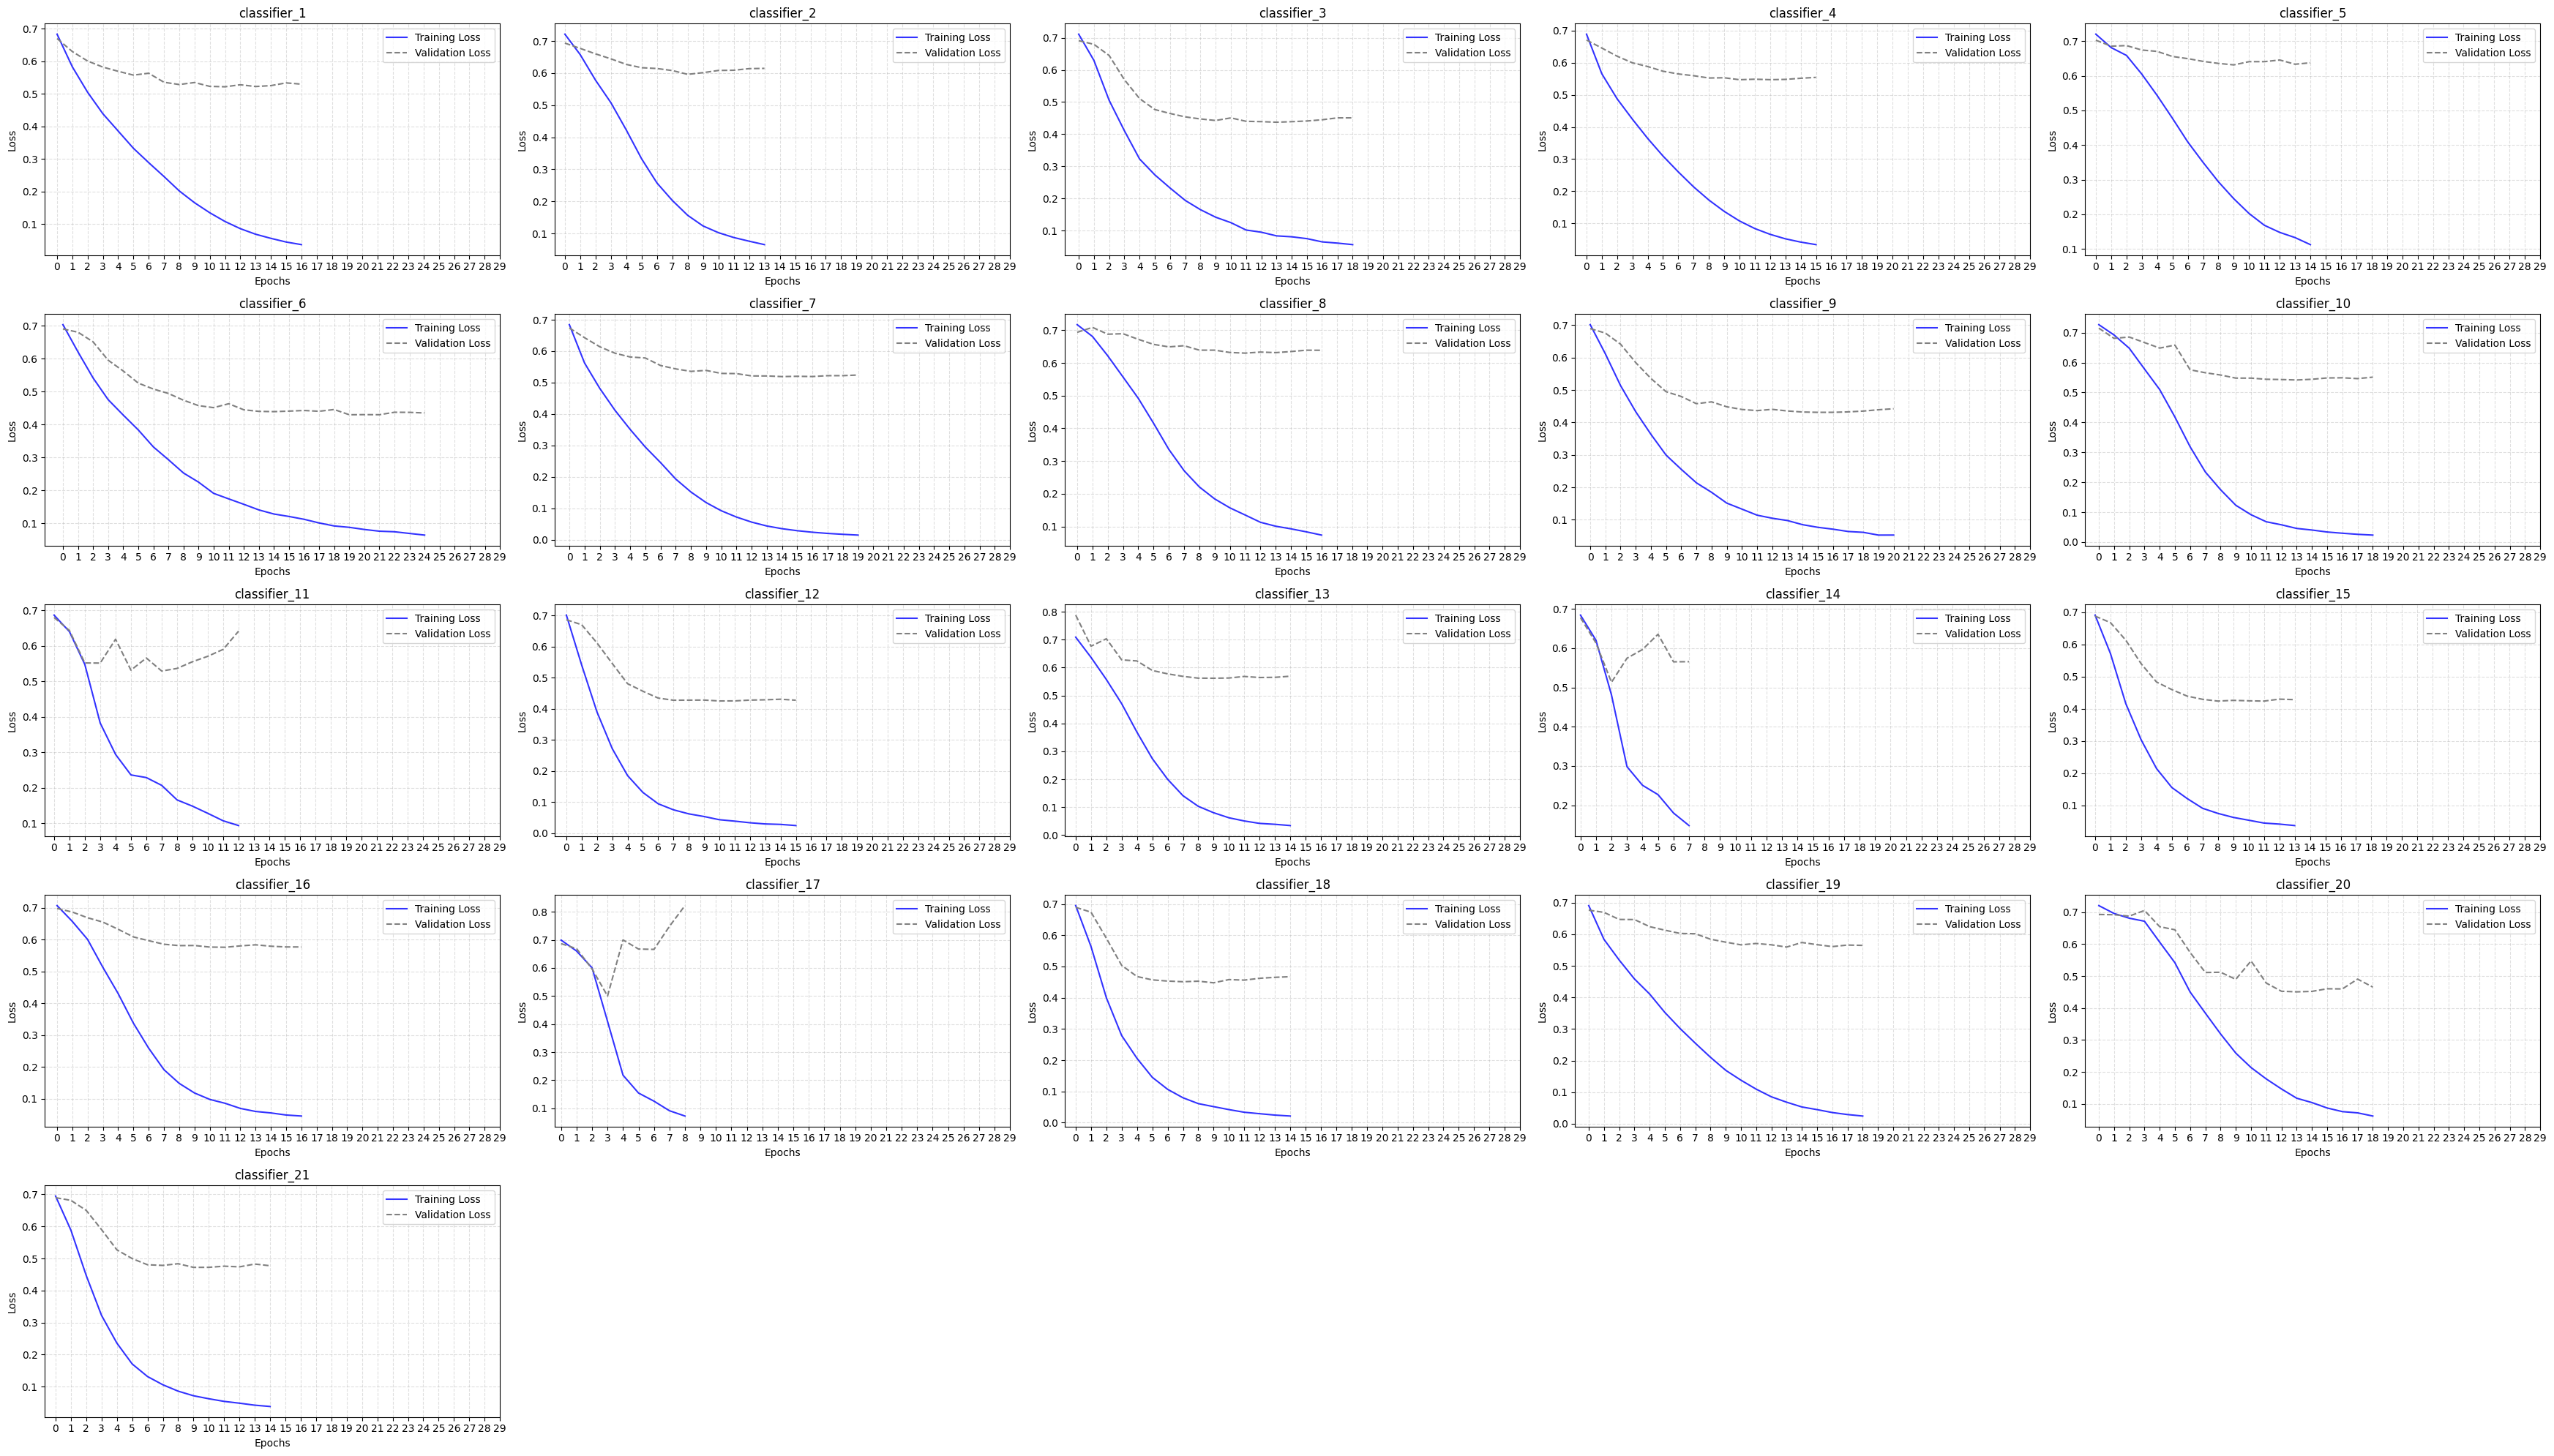

In [ ]:
# Creating a figure with 5 rows and 5 columns
fig, axes = plt.subplots(5, 5, figsize=(35, 20))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterating over the training results of the classifiers
for key, value in training_results.items():

    # Getting the current plot
    ax = axes[int(key.split("_")[1]) - 1]

    # Plotting the lines
    ax.plot(
        value["training_losses"],
        label="Training Loss",
        linestyle="-",
        alpha=0.8,
        color="blue",
    )
    ax.plot(
        value["validation_losses"],
        label="Validation Loss",
        linestyle="--",
        color="grey",
    )

    # Setting plot parameters
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_xticks(list(range(epochs)))
    ax.set_title(key)
    ax.legend()
    ax.grid(True, which="both", linestyle="--", linewidth=0.8, alpha=0.4)

# Removing axes for any unused subplot
axes[21].axis("off")
axes[22].axis("off")
axes[23].axis("off")
axes[24].axis("off")

# Adjusting the layout and showing the plots
plt.tight_layout()
plt.show()

In [ ]:
print(
    f"""
      Best validation loss for classifier_3: {min(enumerate(training_results['classifier_3']['validation_losses'], start=1), key=lambda x: x[1])}
      Best validation loss for classifier_6: {min(enumerate(training_results['classifier_6']['validation_losses'], start=1), key=lambda x: x[1])}
      Best validation loss for classifier_9: {min(enumerate(training_results['classifier_9']['validation_losses'], start=1), key=lambda x: x[1])}
      Best validation loss for classifier_12: {min(enumerate(training_results['classifier_12']['validation_losses'], start=1), key=lambda x: x[1])}
      Best validation loss for classifier_15: {min(enumerate(training_results['classifier_15']['validation_losses'], start=1), key=lambda x: x[1])}
      Best validation loss for classifier_18: {min(enumerate(training_results['classifier_18']['validation_losses'], start=1), key=lambda x: x[1])}
      Best validation loss for classifier_20: {min(enumerate(training_results['classifier_20']['validation_losses'], start=1), key=lambda x: x[1])}
      Best validation loss for classifier_21: {min(enumerate(training_results['classifier_21']['validation_losses'], start=1), key=lambda x: x[1])}
    """
)


      Best validation loss for classifier_3: (14, 0.4372026100754738)
      Best validation loss for classifier_6: (20, 0.4293646365404129)
      Best validation loss for classifier_9: (16, 0.4311446025967598)
      Best validation loss for classifier_12: (11, 0.42553676664829254)
      Best validation loss for classifier_15: (9, 0.42406032234430313)
      Best validation loss for classifier_18: (10, 0.4479193240404129)
      Best validation loss for classifier_20: (14, 0.45064474642276764)
      Best validation loss for classifier_21: (10, 0.4723001644015312)
    


After testing multiple CNN classifiers with different parameter values and text representations and analyzing the training loss and validation loss curves according to the above plots, classifier_15 emerged as the best model, achieving a validation loss of 0.4240 at epoch 9, slightly lower than other classifiers with good performance.

Display the classification scores of the best CNN classifier on all datasets (training, validation, test)

In [ ]:
# Creating the first level of headers
table_headers_level_1 = [
    "",
    "\033[1mTraining Dataset\033[0m",
    "",
    "",
    "",
    "\033[1mValidation Dataset\033[0m",
    "",
    "",
    "",
    "\033[1mTest Dataset\033[0m",
    "",
    "",
    "",
]

# Creating the second level of headers
table_headers_level_2 = [
    "",
    "\033[1mPrecision\033[0m",
    "\033[1mRecall\033[0m",
    "\033[1mf1-Score\033[0m",
    "\033[1mPrecission-Recall AUC Score\033[0m",
    "\033[1mPrecision\033[0m",
    "\033[1mRecall\033[0m",
    "\033[1mf1-Score\033[0m",
    "\033[1mPrecission-Recall AUC Score\033[0m",
    "\033[1mPrecision\033[0m",
    "\033[1mRecall\033[0m",
    "\033[1mf1-Score\033[0m",
    "\033[1mPrecission-Recall AUC Score\033[0m",
]

# Creating the table values
table_data = [
    [
        "neg",
        round(training_results["classifier_15"]["training_scores"]["neg"]["precision"], 4),
        round(training_results["classifier_15"]["training_scores"]["neg"]["recall"], 4),
        round(training_results["classifier_15"]["training_scores"]["neg"]["f1-score"], 4),
        round(training_results["classifier_15"]["training_scores"]["neg"]["precision-recall-auc"], 4),
        round(training_results["classifier_15"]["validation_scores"]["neg"]["precision"], 4),
        round(training_results["classifier_15"]["validation_scores"]["neg"]["recall"], 4),
        round(training_results["classifier_15"]["validation_scores"]["neg"]["f1-score"], 4),
        round(training_results["classifier_15"]["validation_scores"]["neg"]["precision-recall-auc"], 4),
        round(training_results["classifier_15"]["test_scores"]["neg"]["precision"], 4),
        round(training_results["classifier_15"]["test_scores"]["neg"]["recall"], 4),
        round(training_results["classifier_15"]["test_scores"]["neg"]["f1-score"], 4),
        round(training_results["classifier_15"]["test_scores"]["neg"]["precision-recall-auc"], 4),
    ],
    [
        "pos",
        round(training_results["classifier_15"]["training_scores"]["pos"]["precision"], 4),
        round(training_results["classifier_15"]["training_scores"]["pos"]["recall"], 4),
        round(training_results["classifier_15"]["training_scores"]["pos"]["f1-score"], 4),
        round(training_results["classifier_15"]["training_scores"]["pos"]["precision-recall-auc"], 4),
        round(training_results["classifier_15"]["validation_scores"]["pos"]["precision"], 4),
        round(training_results["classifier_15"]["validation_scores"]["pos"]["recall"], 4),
        round(training_results["classifier_15"]["validation_scores"]["pos"]["f1-score"], 4),
        round(training_results["classifier_15"]["validation_scores"]["pos"]["precision-recall-auc"], 4),
        round(training_results["classifier_15"]["test_scores"]["pos"]["precision"], 4),
        round(training_results["classifier_15"]["test_scores"]["pos"]["recall"], 4),
        round(training_results["classifier_15"]["test_scores"]["pos"]["f1-score"], 4),
        round(training_results["classifier_15"]["test_scores"]["pos"]["precision-recall-auc"], 4),
    ],
    [
        "macro-average",
        round(training_results["classifier_15"]["training_scores"]["macro avg"]["precision"], 4),
        round(training_results["classifier_15"]["training_scores"]["macro avg"]["recall"], 4),
        round(training_results["classifier_15"]["training_scores"]["macro avg"]["f1-score"], 4),
        round(training_results["classifier_15"]["training_scores"]["macro avg"]["precision-recall-auc"], 4),
        round(training_results["classifier_15"]["validation_scores"]["macro avg"]["precision"], 4),
        round(training_results["classifier_15"]["validation_scores"]["macro avg"]["recall"], 4),
        round(training_results["classifier_15"]["validation_scores"]["macro avg"]["f1-score"], 4),
        round(training_results["classifier_15"]["validation_scores"]["macro avg"]["precision-recall-auc"], 4),
        round(training_results["classifier_15"]["test_scores"]["macro avg"]["precision"], 4),
        round(training_results["classifier_15"]["test_scores"]["macro avg"]["recall"], 4),
        round(training_results["classifier_15"]["test_scores"]["macro avg"]["f1-score"], 4),
        round(training_results["classifier_15"]["test_scores"]["macro avg"]["precision-recall-auc"], 4),
    ],
]

# Showing the classification scores

print(f"\033[1m{'Classification Scores':^200}\033[0m")
print()
print(
    tabulate(
        [table_headers_level_2] + table_data,
        headers=table_headers_level_1,
        tablefmt="rounded_grid",
    )
)

                                                                                         Classification Scores                                                                                          

╭───────────────┬────────────────────┬────────┬──────────┬─────────────────────────────┬──────────────────────┬────────┬──────────┬─────────────────────────────┬────────────────┬────────┬──────────┬─────────────────────────────╮
│               │ Training Dataset   │        │          │                             │ Validation Dataset   │        │          │                             │ Test Dataset   │        │          │                             │
├───────────────┼────────────────────┼────────┼──────────┼─────────────────────────────┼──────────────────────┼────────┼──────────┼─────────────────────────────┼────────────────┼────────┼──────────┼─────────────────────────────┤
│               │ Precision          │ Recall │ f1-Score │ Precission-Recall AUC Score │ Precision            │